## Image object-detection using MMDetection specific pipeline component

This sample shows how to use `mmdetection_image_objectdetection_instancesegmentation_pipeline` component from the `azureml` system registry to fine tune a model for image object-detection task using fridgeObjects Dataset. We then deploy the fine tuned model to an online endpoint for real time inference.

### Training data
We will use the [surfacelandmines](https://github.com/UnVeilX/slm-od-ml-comparison/tree/main/datasets) dataset.

### Model
We will use the `yolof_r50_c5_8x8_1x_coco` model in this notebook. If you need to fine tune a model that is available on MMDetection model zoo, but not available in `azureml` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from MMDetection model zoo.

### Outline
1. Install dependencies
2. Setup pre-requisites such as compute
3. Pick a model to fine tune
4. Prepare dataset for finetuning the model
5. Submit the fine tuning job using MMDetection specific image object-detection and instance-segmentation component
6. Review training and evaluation metrics
7. Register the fine tuned model
8. Deploy the fine tuned model for real time inference
9. Test deployed end point
9. Clean up resources

### 1. Install dependencies
Before starting off, if you are running the notebook on Azure Machine Learning Studio or running first time locally, you will need the following packages

In [1]:
! pip install azure-ai-ml==1.8.0
! pip install azure-identity==1.13.0

### 2. Setup pre-requisites

#### 2.1 Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We are using `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [set up authentication doc](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk), [azure-identity reference doc](https://learn.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

Replace `<AML_WORKSPACE_NAME>`, `<RESOURCE_GROUP>` and `<SUBSCRIPTION_ID>` with their respective values in the below cell.

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


experiment_name = (
    "AzureML-Train-Finetune-Vision-OD-UVXDataset12-2_5-Y"  # can rename to any valid name
)

credential = DefaultAzureCredential()
workspace_ml_client = None
try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "fdb5d841-c563-47cd-9530-53dbd266c1fb"
    resource_group = "rg-unveilx"
    workspace_name = "ml-landlmine"

workspace_ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azureml",
)

Found the config file in: /config.json


#### 2.2 Create compute

In order to finetune a model on Azure Machine Learning studio, you will need to create a compute resource first. **Creating a compute will take 3-4 minutes.** 

For additional references, see [Azure Machine Learning in a Day](https://github.com/Azure/azureml-examples/blob/main/tutorials/azureml-in-a-day/azureml-in-a-day.ipynb). 

##### Create CPU compute for model selection component

In [3]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

model_import_cluster_name = "ldm-cpu-cluster"
try:
    _ = workspace_ml_client.compute.get(model_import_cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=model_import_cluster_name,
        type="amlcompute",
        size="Standard_E4ds_v4",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


##### Create GPU compute for finetune component

The list of GPU machines can be found [here](https://learn.microsoft.com/en-us/azure/virtual-machines/sizes-gpu).

In [4]:
finetune_cluster_name = "aml-cv-bg-cl"

try:
    _ = workspace_ml_client.compute.get(finetune_cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=finetune_cluster_name,
        type="amlcompute",
        size="Standard_ND40rs_v2",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


##### Create GPU compute for model evaluation component

The list of GPU machines can be found [here](https://learn.microsoft.com/en-us/azure/virtual-machines/sizes-gpu).

In [5]:
import time
import warnings

# Using the same compute cluster for model evaluation as finetuning. If you want to use a different cluster, specify it below
model_eval_cluster_name = "cl-aml-cv-lmd"

try:
    model_evaluation_compute = workspace_ml_client.compute.get(model_eval_cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    model_evaluation_compute = AmlCompute(
        name=model_eval_cluster_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

model_evaluation_compute_instance_type = model_evaluation_compute.size
print(
    f"Model Evaluation compute's instance type: {model_evaluation_compute_instance_type}"
)

if model_evaluation_compute_instance_type != "STANDARD_NC6S_V3":
    # Print a warning message if compute type is not 'STANDARD_NC6S_V3', i.e. Single GPU V100
    warning_message = (
        "Warning! Currently evaluation is only supported on STANDARD_NC6S_V3 compute type."
        " Please change the compute type to STANDARD_NC6S_V3 if you want to run evaluation."
    )
    warnings.warn(warning_message, category=Warning)
# generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

Found existing compute target.
Model Evaluation compute's instance type: STANDARD_NC6S_V3


### 3. Pick a foundation model to fine tune

We will use the `yolof_r50_c5_8x8_1x_coco` model in this notebook. If you need to fine tune a model that is available on MMDetection model zoo, but not available in `azureml` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from MMDetection model zoo.

Currently following models are supported:

| Model Name | Source |
| :------------: | :-------:  |
| [mmd-3x-deformable-detr_refine_twostage_r50_16xb2-50e_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-deformable-detr_refine_twostage_r50_16xb2-50e_coco/version/12) | azureml registry |
| [mmd-3x-sparse-rcnn_r50_fpn_300-proposals_crop-ms-480-800-3x_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-sparse-rcnn_r50_fpn_300-proposals_crop-ms-480-800-3x_coco/version/12) | azureml registry |
| [mmd-3x-sparse-rcnn_r101_fpn_300-proposals_crop-ms-480-800-3x_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-sparse-rcnn_r101_fpn_300-proposals_crop-ms-480-800-3x_coco/version/12) | azureml registry |
| [mmd-3x-vfnet_r50-mdconv-c3-c5_fpn_ms-2x_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-vfnet_r50-mdconv-c3-c5_fpn_ms-2x_coco/version/12) | azureml registry |
| [mmd-3x-vfnet_x101-64x4d-mdconv-c3-c5_fpn_ms-2x_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-vfnet_x101-64x4d-mdconv-c3-c5_fpn_ms-2x_coco/version/12) | azureml registry |
| [mmd-3x-yolof_r50_c5_8x8_1x_coco](https://ml.azure.com/registries/azureml/models/mmd-3x-yolof_r50_c5_8x8_1x_coco/version/12) | azureml registry |
| [Image object detection models from MMDetection](https://github.com/open-mmlab/mmdetection/blob/v3.1.0/docs/en/model_zoo.md) | MMDetection |

In [6]:
mmdetection_model_name = "yolof_r50_c5_8x8_1x_coco"

aml_registry_model_name = "mmd-3x-yolof_r50_c5_8x8_1x_coco"
foundation_models = registry_ml_client.models.list(name=aml_registry_model_name)
foundation_model = max(foundation_models, key=lambda x: int(x.version))
print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for inferencing"
)



Using model name: mmd-3x-yolof_r50_c5_8x8_1x_coco, version: 12, id: azureml://registries/azureml/models/mmd-3x-yolof_r50_c5_8x8_1x_coco/versions/12 for inferencing


### 4. Prepare the dataset for fine-tuning the model

We will use the [surfacelandmines](https://github.com/UnVeilX/slm-od-ml-comparison/tree/main/datasets), a dataset called Surface Landmines Objects, which consists of 78 images of 1 label of  {`landmine`} photos taken on different backgrounds.


#### 4.1 Download the Data and upload to Azure Machine Learning Studio Data Labeling

#### 4.5 Point to MLTable data input

In [7]:
training_mltable_path = "azureml://subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourcegroups/rg-unveilx/workspaces/ml-landmine/datastores/workspaceblobstore/paths/Labeling/export/export/dataset/5149b250-fbc8-404a-8a5b-b981b0535a4c/c460db57-4906-43e7-b8d1-07fec61d07f4/"
validation_mltable_path = "azureml://subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourcegroups/rg-unveilx/workspaces/ml-landmine/datastores/workspaceblobstore/paths/Labeling/export/export/dataset/d43b0582-c86e-4bbe-9e60-a9f29b13966e/06fb66fe-f227-4539-a04d-2c81ed537550/"

### 5. Submit the fine tuning job using `mmdetection_image_objectdetection_instancesegmentation_pipeline` component
 
Create the job that uses the `mmdetection_image_objectdetection_instancesegmentation_pipeline` component for image object detection and instance segmentation tasks. Learn more in 5.2 about all the parameters supported for fine tuning.

#### 5.1 Create component

In [8]:
FINETUNE_PIPELINE_COMPONENT_NAME = (
    "mmdetection_image_objectdetection_instancesegmentation_pipeline"
)
pipeline_component_mmdetection_func = registry_ml_client.components.get(
    name=FINETUNE_PIPELINE_COMPONENT_NAME, label="latest"
)

#### 5.2 Create arguments to be passed to `mmdetection_image_objectdetection_instancesegmentation_pipeline` component

The `mmdetection_image_objectdetection_instancesegmentation_pipeline` component consists of model selection and finetuning components. The detailed arguments for each component can be found at following README files:
- [Model Import Component](../../docs/component_docs/image_finetune/mmd_model_import_component.md)
- [Finetune Component](../../docs/component_docs/image_finetune/mmd_finetune_component.md)

In [9]:
deepspeed_config_path = "./deepspeed_configs/zero1.json"
if not os.path.exists(deepspeed_config_path):
    print("DeepSpeed config file not found")
    deepspeed_config_path = None

pipeline_component_args = {
    # # Model import args
    "model_family": "MmDetectionImage",
    "download_from_source": False,  # True for downloading a model directly from MMDetection
    "mlflow_model": foundation_model.id,  # foundation_model.id is provided, only foundation_model gives UserErrorException: only path input is supported now but get: ...
    # "model_name": mmdetection_model_name, # specify the model_name instead of mlflow_model if you want to use a model from the mmdetection model zoo
    # Finetune args
    "task_name": "image-object-detection",
    "apply_augmentations": True,
    "number_of_workers": 8,
    "apply_deepspeed": False,
    "deepspeed_config": deepspeed_config_path,
    "apply_ort": False,
    "auto_find_batch_size": False,
    "extra_optim_args": "",
    "precision": "32",
    "random_seed": 42,
    "evaluation_strategy": "epoch",
    "evaluation_steps": 500,
    "logging_strategy": "epoch",
    "logging_steps": 500,
    "save_strategy": "epoch",
    "save_steps": 500,
    "save_total_limit": -1,
    "early_stopping": False,
    "early_stopping_patience": 1,
    "resume_from_checkpoint": False,
    "save_as_mlflow_model": True,
    # # Uncomment one or more lines below to provide specific values, if you wish you override the autoselected default values.
    # "image_min_size": -1,
    # "image_max_size": -1,
    # "metric_for_best_model": "mean_average_precision",
    # "number_of_epochs": 15,
    # "max_steps": -1,
    # "training_batch_size": 4,
    # "validation_batch_size": 4,
    # "learning_rate": 5e-5,
    # "learning_rate_scheduler": "warmup_linear",
    # "warmup_steps": 0,
    # "optimizer": "adamw_hf",
    # "weight_decay": 0.0,
    # "gradient_accumulation_step": 1,
    # "max_grad_norm": 1.0,
    # "iou_threshold": 0.5,
    # "box_score_threshold": 0.3,
    # # Model evaluation args
    # The following parameters map to the dataset fields
    # Uncomment one or more lines below to provide specific values, if you wish you override the autoselected default values.
    # "label_column_name": "label",
    # "input_column_names": "image_url",
}
instance_count = 1
process_count_per_instance = 1

# Ensure that the user provides only one of mlflow_model or model_name
if (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is None
):
    raise ValueError(
        "You must specify either mlflow_model or model_name for the model to finetune"
    )
if (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is not None
):
    raise ValueError(
        "You must specify ONLY one of mlflow_model and model_name for the model to finetune"
    )
elif (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is not None
):
    use_model_name = mmdetection_model_name
elif (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is None
):
    use_model_name = aml_registry_model_name
print(f"Finetuning model {use_model_name}")

DeepSpeed config file not found
Finetuning model mmd-3x-yolof_r50_c5_8x8_1x_coco


#### 5.3 Utility function to create pipeline using `mmdetection_image_objectdetection_instancesegmentation_pipeline` component

In [10]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import PipelineComponent
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes


@pipeline()
def create_pipeline_mmdetection():
    """Create pipeline."""

    mmdetection_pipeline_component: PipelineComponent = pipeline_component_mmdetection_func(
        compute_model_import=model_import_cluster_name,
        compute_finetune=finetune_cluster_name,
        compute_model_evaluation=model_eval_cluster_name,
        training_data=Input(type=AssetTypes.MLTABLE, path=training_mltable_path),
        validation_data=Input(type=AssetTypes.MLTABLE, path=validation_mltable_path),
        # test data
        # Using the same data for validation and test. If you want to use a different dataset for test, specify it below
        test_data=Input(type=AssetTypes.MLTABLE, path=validation_mltable_path),
        instance_count=instance_count,
        process_count_per_instance=process_count_per_instance,
        **pipeline_component_args,
    )
    return {
        # Map the output of the fine tuning job to the output of pipeline job so that we can easily register the fine tuned model. Registering the model is required to deploy the model to an online or batch endpoint.
        "trained_model": mmdetection_pipeline_component.outputs.mlflow_model_folder,
    }

#### 5.4 Run the fine tuning job using `mmdetection_image_objectdetection_instancesegmentation_pipeline` component

In [31]:
mmdetection_pipeline_object = create_pipeline_mmdetection()

# don't use cached results from previous jobs
mmdetection_pipeline_object.settings.force_rerun = True

# set continue on step failure to False
mmdetection_pipeline_object.settings.continue_on_step_failure = False

mmdetection_pipeline_object.display_name = (
    use_model_name + "_mmdetection_pipeline_component_run_" + "od"
)
# Don't use cached results from previous jobs
mmdetection_pipeline_object.settings.force_rerun = True

print("Submitting pipeline")

mmdetection_pipeline_run = workspace_ml_client.jobs.create_or_update(
    mmdetection_pipeline_object, experiment_name=experiment_name
)

print(f"Pipeline created. URL: {mmdetection_pipeline_run.studio_url}")

Submitting pipeline
Pipeline created. URL: https://ml.azure.com/runs/willing_pot_4qcxynpp5x?wsid=/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourcegroups/rg-unveilx/workspaces/ml-landmine&tid=16b3c013-d300-468d-ac64-7eda0820b6d3


In [32]:
workspace_ml_client.jobs.stream(mmdetection_pipeline_run.name)

RunId: willing_pot_4qcxynpp5x
Web View: https://ml.azure.com/runs/willing_pot_4qcxynpp5x?wsid=/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourcegroups/rg-unveilx/workspaces/ml-landmine

Streaming logs/azureml/executionlogs.txt

[2024-08-14 16:18:11Z] Submitting 1 runs, first five are: 88b29304:7d1c8302-3d0b-429a-bffa-fab3e7eb92d9
[2024-08-14 17:14:40Z] Completing processing run id 7d1c8302-3d0b-429a-bffa-fab3e7eb92d9.

Execution Summary
RunId: willing_pot_4qcxynpp5x
Web View: https://ml.azure.com/runs/willing_pot_4qcxynpp5x?wsid=/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourcegroups/rg-unveilx/workspaces/ml-landmine



### 6. Get metrics from finetune component

The model training happens as part of the finetune component. Please follow below steps to extract validation metrics from the run.

##### 6.1 Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT - You need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow
    pip install mlflow

In [33]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = workspace_ml_client.workspaces.get(
    name=workspace_ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westus2.api.azureml.ms/mlflow/v1.0/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourceGroups/rg-unveilx/providers/Microsoft.MachineLearningServices/workspaces/ml-landmine


In [34]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westus2.api.azureml.ms/mlflow/v1.0/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourceGroups/rg-unveilx/providers/Microsoft.MachineLearningServices/workspaces/ml-landmine


In [35]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

#### 6.2 Get the training and evaluation run

Fetch the training and evaluation run ids from the above pipeline run. We will later use these run ids to fetch the metrics. We will use the training run id to register the model.

In [36]:
# Concat 'tags.mlflow.rootRunId=' and pipeline_job.name in single quotes as filter variable
filter = "tags.mlflow.rootRunId='" + mmdetection_pipeline_run.name + "'"
runs = mlflow.search_runs(
    experiment_names=[experiment_name], filter_string=filter, output_format="list"
)

# Get the training and evaluation runs.
# Using a hacky way till 'Bug 2320997: not able to show eval metrics in FT notebooks - mlflow client now showing display names' is fixed
for run in runs:
    # Check if run.data.metrics.epoch exists
    if "epoch" in run.data.metrics:
        training_run = run
    # Else, check if run.data.metrics.accuracy exists
    elif "mean_average_precision" in run.data.metrics:
        evaluation_run = run

#### 6.3 Get training metrics

Access the results (such as Models, Artifacts, Metrics) of a previously completed run.

In [37]:
import pandas as pd

pd.DataFrame(training_run.data.metrics, index=[0]).T

,0
loss,0.245000
grad_norm,9.950342
learning_rate,0.000000
epoch,15.000000
recall,1.000000
precision,1.000000
mean_average_precision,1.000000
runtime,4.394000
samples_per_second,3.869000
steps_per_second,1.138000


### 7. Register the fine tuned model with the workspace

We will register the model from the output of the fine tuning job. This will track lineage between the fine tuned model and the fine tuning job. The fine tuning job, further, tracks lineage to the foundation model, data and training code.

In [38]:
import time

# Generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

In [39]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

# Check if the `trained_model` output is available
print(
    f"Pipeline job outputs: {workspace_ml_client.jobs.get(mmdetection_pipeline_run.name).outputs}"
)

# Fetch the model from pipeline job output - not working, hence fetching from fine tune child job
model_path_from_job = (
    f"azureml://jobs/{mmdetection_pipeline_run.name}/outputs/trained_model"
)
print(f"Path to register model: {model_path_from_job}")

finetuned_model_name = f"{use_model_name.replace('/', '-')}-fridge-objects-od"
finetuned_model_description = f"{use_model_name.replace('/', '-')} fine tuned model for fridge objects object detection"
prepare_to_register_model = Model(
    path=model_path_from_job,
    type=AssetTypes.MLFLOW_MODEL,
    name=finetuned_model_name,
    version=timestamp,  # Use timestamp as version to avoid version conflict
    description=finetuned_model_description,
)
print(f"Prepare to register model: \n{prepare_to_register_model}")

# Register the model from pipeline job output
registered_model = workspace_ml_client.models.create_or_update(
    prepare_to_register_model
)
print(f"Registered model: {registered_model}")

Pipeline job outputs: {'trained_model': <azure.ai.ml.entities._job.pipeline._io.base.PipelineOutput object at 0x7fec5ce3e730>}
Path to register model: azureml://jobs/willing_pot_4qcxynpp5x/outputs/trained_model
Prepare to register model: 
description: mmd-3x-yolof_r50_c5_8x8_1x_coco fine tuned model for fridge objects object
  detection
name: mmd-3x-yolof_r50_c5_8x8_1x_coco-fridge-objects-od
path: azureml://jobs/willing_pot_4qcxynpp5x/outputs/trained_model
properties: {}
tags: {}
type: mlflow_model
version: '1723656554'

Registered model: creation_context:
  created_at: '2024-08-14T17:29:50.260000+00:00'
  created_by: Rashid Moin
  created_by_type: User
  last_modified_at: '2024-08-14T17:29:50.260000+00:00'
  last_modified_by: Rashid Moin
  last_modified_by_type: User
description: mmd-3x-yolof_r50_c5_8x8_1x_coco fine tuned model for fridge objects object
  detection
flavors:
  python_function:
    artifacts: "{\n  \"augmentations_path\": {\n    \"path\": \"artifacts/augmentations.yaml\

### 8. Deploy the fine tuned model to an online endpoint
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

In [41]:
import datetime
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
online_endpoint_name = "mmd-od-landmine-" + datetime.datetime.now().strftime(
    "%m%d%H%M"
)
online_endpoint_description = f"Online endpoint for {registered_model.name}, finetuned for fridge objects object detection"
# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description=online_endpoint_description,
    auth_mode="key",
    tags={"foo": "bar"},
)
workspace_ml_client.begin_create_or_update(endpoint).result()

In [ ]:
from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "mmd-od-landmine-mlflow-deploy"
print(registered_model.id)
print(online_endpoint_name)
print(deployment_name)

# Create a deployment
demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS3_V2",
    instance_count=1,
    request_settings=OnlineRequestSettings(
        max_concurrent_requests_per_instance=1,
        request_timeout_ms=90000,
        max_queue_wait_ms=500,
    ),
    liveness_probe=ProbeSettings(
        failure_threshold=49,
        success_threshold=1,
        timeout=299,
        period=180,
        initial_delay=180,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=10,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {deployment_name: 100}
workspace_ml_client.begin_create_or_update(endpoint).result()

### 9. Test the endpoint with sample data

We will fetch some sample data from the test dataset and submit to online endpoint for inference. We will then display the scored labels alongside the ground truth labels.

In [12]:
demo_deployment = workspace_ml_client.online_deployments.get(
    name="yolof-landmine",
    endpoint_name="mmd-od-landmine-08141731",
)

# Get the details for online endpoint
endpoint = workspace_ml_client.online_endpoints.get(name="mmd-od-landmine-08141731")

# existing traffic details
print(endpoint.traffic)
# Get the scoring URI
print(endpoint.scoring_uri)
print(demo_deployment)

{'yolof-landmine': 0}
https://mmd-od-landmine-08141731.westus2.inference.ml.azure.com/score
app_insights_enabled: false
egress_public_network_access: enabled
endpoint_name: mmd-od-landmine-08141731
environment: azureml:/subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourceGroups/rg-unveilx/providers/Microsoft.MachineLearningServices/workspaces/ml-landmine/environments/DefaultNcdEnv-mlflow-ubuntu20-04-py38-cpu-inference/versions/20240805v1
environment_variables:
  AZUREML_EXTRA_CONDA_YAML_ABS_PATH: /var/azureml-app/azureml-models/mmd-3x-yolof_r50_c5_8x8_1x_coco-fridge-objects-od/1723656554/mlflow_model_folder/conda.yaml
  AZUREML_MODEL_DIR: /var/azureml-app/azureml-models/mmd-3x-yolof_r50_c5_8x8_1x_coco-fridge-objects-od/1723656554
  MLFLOW_MODEL_FOLDER: mlflow_model_folder
id: /subscriptions/fdb5d841-c563-47cd-9530-53dbd266c1fb/resourceGroups/rg-unveilx/providers/Microsoft.MachineLearningServices/workspaces/ml-landmine/onlineEndpoints/mmd-od-landmine-08141731/deployments/yolof-la

In [14]:
# Create request json
import base64
import json

#sample_image = os.path.join(dataset_dir, "images", "DJI_0086.JPG")

sample_image = "DJI_0086.JPG"


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [15]:
resp = workspace_ml_client.online_endpoints.invoke(
    endpoint_name="mmd-od-landmine-08141731",
    deployment_name="yolof-landmine",
    request_file=request_file_name,
)

In [16]:
resp

'[{"boxes": [{"box": {"topX": 0.4208013117313385, "topY": 0.41559305787086487, "bottomX": 0.5002232193946838, "bottomY": 0.5457226037979126}, "label": "landmine", "score": 0.8160059452056885}]}]'

#### Visualize detections
Now that we have scored a test image, we can visualize the prediction for this image.

In [17]:
! pip install matplotlib
! pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-datadrift 1.56.0 requires matplotlib<=3.6.3,>=3.0.2, but you have matplotlib 3.9.2 which is incompatible.


landmine 1: [1683.205, 935.084, 317.688, 292.791], 0.816


/tmp/ipykernel_13516/1791449146.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=sorted_scores, y=unique_labels, palette=sorted_colors, ax=ax2)
/tmp/ipykernel_13516/1791449146.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


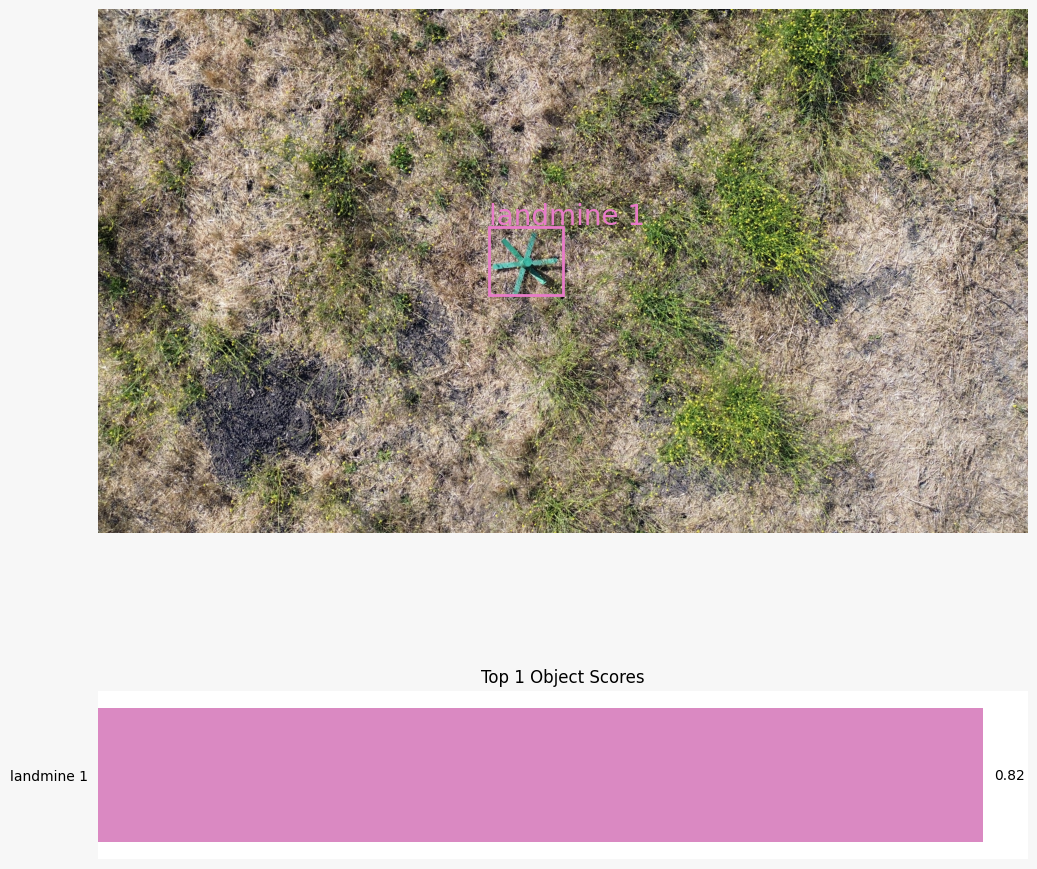

In [17]:
%matplotlib inline
import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size
conf_threshold = 0.6  # display top objects with confidence score > 0.6

# Set a compact figure size
fig_width = 12
fig_height = 12

# Initialize figure and axes
fig = plt.figure(figsize=(fig_width, fig_height))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Display the image with bounding boxes and segmentation maps
ax1.imshow(img_np)
ax1.axis("off")

# Draw bounding boxes and segmentation maps for each detection
detections = json.loads(resp)
sorted_data = sorted(detections[0]["boxes"], key=lambda x: x["score"], reverse=True)
sorted_scores = []
sorted_colors = []
unique_labels = []
label_counter = {}

# draw box and label for each detection
for detect in sorted_data:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]

    if conf_score > conf_threshold:
        # Modify labels to make them unique with numbering
        if label not in label_counter:
            label_counter[label] = 1
            unique_labels.append(f"{label} {label_counter[label]}")
        else:
            label_counter[label] += 1
            unique_labels.append(f"{label} {label_counter[label]}")

        current_label = unique_labels[-1]

        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{current_label}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )

        color = np.random.rand(3)
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax1.add_patch(rect)
        ax1.text(topleft_x, topleft_y - 10, current_label, color=color, fontsize=20)
        sorted_scores.append(conf_score)
        sorted_colors.append(color)

# Set a stylish color palette
sns.set_palette("pastel")

# Create the bar plot without x-axis and y-axis markings
barplot = sns.barplot(x=sorted_scores, y=unique_labels, palette=sorted_colors, ax=ax2)
ax2.set_xlabel("")  # Remove x-axis label
ax2.set_ylabel("")  # Remove y-axis label
ax2.set_title(f"Top {len(sorted_scores)} Object Scores", fontsize=12)

# Add scores in front of the bars
for index, value in enumerate(sorted_scores):
    barplot.text(
        value + 0.01, index, f"{value:.2f}", va="center", color="black", fontsize=10
    )

# Remove spines and ticks from the bar plot
barplot.spines["left"].set_visible(False)
barplot.spines["top"].set_visible(False)
barplot.spines["right"].set_visible(False)
barplot.spines["bottom"].set_visible(False)
barplot.tick_params(left=False, top=False, right=False, bottom=False)
barplot.xaxis.set_visible(False)  # Remove x-axis
barplot.yaxis.grid(False)  # Remove y-axis grid

# Set plot background color
fig.patch.set_facecolor("#F7F7F7")  # Light gray

plt.tight_layout()
# fig.savefig("plot.png", bbox_inches="tight")
plt.show()

### 10. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [ ]:
workspace_ml_client.online_endpoints.begin_delete(name=online_endpoint_name).wait()